In [2]:
import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

dataset = pd.read_csv("../../data/emotion.data", engine='python')

In [3]:
labels = dataset["emotions"].values.tolist()
input_sentences = dataset["text"].values.tolist()

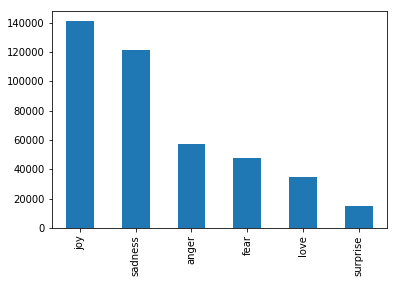

In [4]:
%matplotlib inline
dataset.emotions.value_counts().plot.bar()

In [5]:
# dataset.head(100)

In [6]:
# Tokenization

input_sentences = [text.split(" ") for text in dataset["text"].values.tolist()]
labels = dataset["emotions"].values.tolist()

In [7]:
# Creating Vocabulary (word index)

word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word not in word2id:
                word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)

# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}

#label2id

In [8]:
# Encoding samples with corresponding integer values

import keras

# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]

# Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))

Using TensorFlow backend.


Shape of X: (416809, 178)
Shape of Y: (416809, 6)


In [9]:
# Build LSTM model with attention

embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs = keras.layers.Embedding(len(word2id)+1, embedding_dim, input_length=max_words)(sequence_input)
# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(keras.layers.LSTM(embedding_dim, return_sequences=True))(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism = Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 178)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 178, 100)     7530300     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 178, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 178, 200)     160800      dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [12]:
# Train model 2 iterations
model.fit(X, Y, epochs=2, batch_size=64, validation_split=0.1, shuffle=True)

In [10]:
import json 

# way 1
# model.save('my_model_0228.h5')  # creates a HDF5 file 'my_model.h5'

# way 2
model.save_weights('my_model_weights.h5')
json_string = model.to_json()
with open("model.json","w") as f:
    json.dump(json_string, f)

In [11]:
# ----------Load Model----------

# import keras
# from keras.models import load_model

# model = load_model('../../my_model_0228.h5')
# model_with_attentions = keras.Model(inputs=model.input,outputs=[model.output,model.get_layer('attention_vec').output])

import json
import keras
from keras.models import model_from_json

model_json_file = "model.json"
model_weight = "my_model_weights.h5"


with open(model_json_file, 'r') as load_f:
    load_dict = json.load(load_f)

model = model_from_json(load_dict)
model.load_weights(model_weight)

model_with_attentions = keras.Model(inputs=model.input,outputs=[model.output,model.get_layer('attention_vec').output])

In [14]:
import random
import math

max_words = 178

# Select random samples to illustrate
# sample_text = random.choice(dataset["text"].values.tolist())
sample_text = "i am feeling completely overwhelmed today"

# Encode samples
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples) 
# label_probs: [[8.2146689e-05 4.3992826e-01]]
# attentions: [[7.2281969e-06 6.7639776e-06 ...3.7842035e-02 9.4464678e-01 1.3058153e-03]
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)
# {'i': 0.016325365867506523 attentions[0][-len(tokenized_sample)], 'am': 0.020278888326332324}


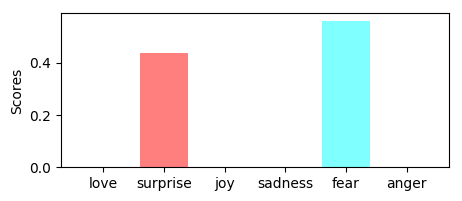

In [13]:
# VISUALIZATION
%matplotlib inline

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'>    <b>Text: </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} </span> ".format(attention2color(attention), token)
html_text += "</p>"

# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]

plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()

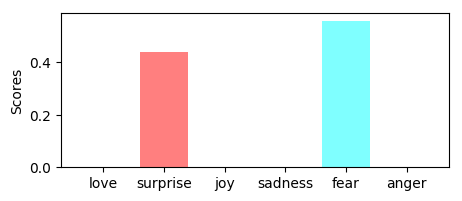